In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import pandas as pd
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import identification.dataset
%matplotlib widget

In [28]:
config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_coeff': 60,
    'sr': 10000,
    'sample_duration': 30,
    'feature': 'MFCC_welch',
    'clf': sklearn.neighbors.KNeighborsClassifier(),
    'clf__n_neighbors': 21,
    'clf__p': 1,
    'clf__weights': 'distance',
    # 'clf': sklearn.svm.SVC(),
    # 'clf__decision_function_shape': 'ovr',
    # 'clf__kernel': 'linear',
    # 'clf__C': 1.0,
}

In [5]:
# data = pd.read_pickle('../data/processed/dataset_bilbao.pkl')
# data = data[data.type.isin(['scale']) & (data.player != 15)]

data = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
data = data[(data.violin.isin(['A', 'B', 'C'])) & (data.extract != '?')]

features = identification.dataset.get_dataset(config, data)

100%|██████████| 937/937 [00:29<00:00, 31.31it/s]


In [6]:
columns = ['player', 'violin', 'extract']

X_train, X_test = sklearn.model_selection.train_test_split(features, test_size=0.15, random_state=42)

# cond = ~(features.extract == 'sibelius')
# X_train = features[cond]
# X_test = features[~cond]

estimator = config['clf']
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('clf', estimator),
])
valid_params = pipeline.get_params()
params = {x:config[x] for x in config if x in valid_params}
pipeline.set_params(**params)
pipeline.fit(np.vstack(X_train.features), X_train.violin.to_numpy())
test_score = pipeline.score(np.vstack(X_test.features), X_test.violin.to_numpy())
print(f'Test score : {test_score}')

X_test['predicted'] = pipeline.predict(np.vstack(X_test.features))
wrong_idx = X_test.loc[X_test['violin'] != X_test['predicted']].index.tolist()
wrong_pos = np.where(X_test['violin'] != X_test['predicted'])[0]

neigh_dist, neigh_ind = pipeline['clf'].kneighbors(
    pipeline['scaler'].transform(np.vstack(X_test.features))
)

pos = wrong_pos[1]
print(X_test.iloc[pos][columns + ['predicted']])
print(
    X_train.iloc[neigh_ind[pos]][columns]
)

Test score : 0.9345238095238095
player       Hélène
violin            C
extract       tchai
predicted         A
Name: 1069, dtype: object
       player violin extract
326    Hélène      A   tchai
347    Hélène      A   tchai
193   Céleste      A   tchai
1039   Hélène      B   tchai
956    Renato      A   tchai
1070   Hélène      C   tchai
513    Fanton      A   tchai
327    Hélène      A   tchai
916    Fanton      A   tchai
42     Renato      A   tchai
970    Renato      A   tchai
133     Félix      A   tchai
1055   Hélène      A   tchai
471    Norimi      A   tchai
888    Norimi      A   tchai
337    Hélène      B   tchai
462    Norimi      B   tchai
836   Eugénie      A   tchai
63     Renato      A   tchai
963    Renato      C   tchai
338    Hélène      B   tchai


In [46]:
embedding = sklearn.manifold.MDS(n_components=2, n_jobs=-1)
# embedding = sklearn.manifold.Isomap(n_components=2, n_jobs=-1, n_neighbors=config['clf__n_neighbors'])
X = np.vstack(features.features)
X = X[:, [0,4,1,7,11,41,16,3,14]]
points = embedding.fit_transform(X)
x, y = points.T

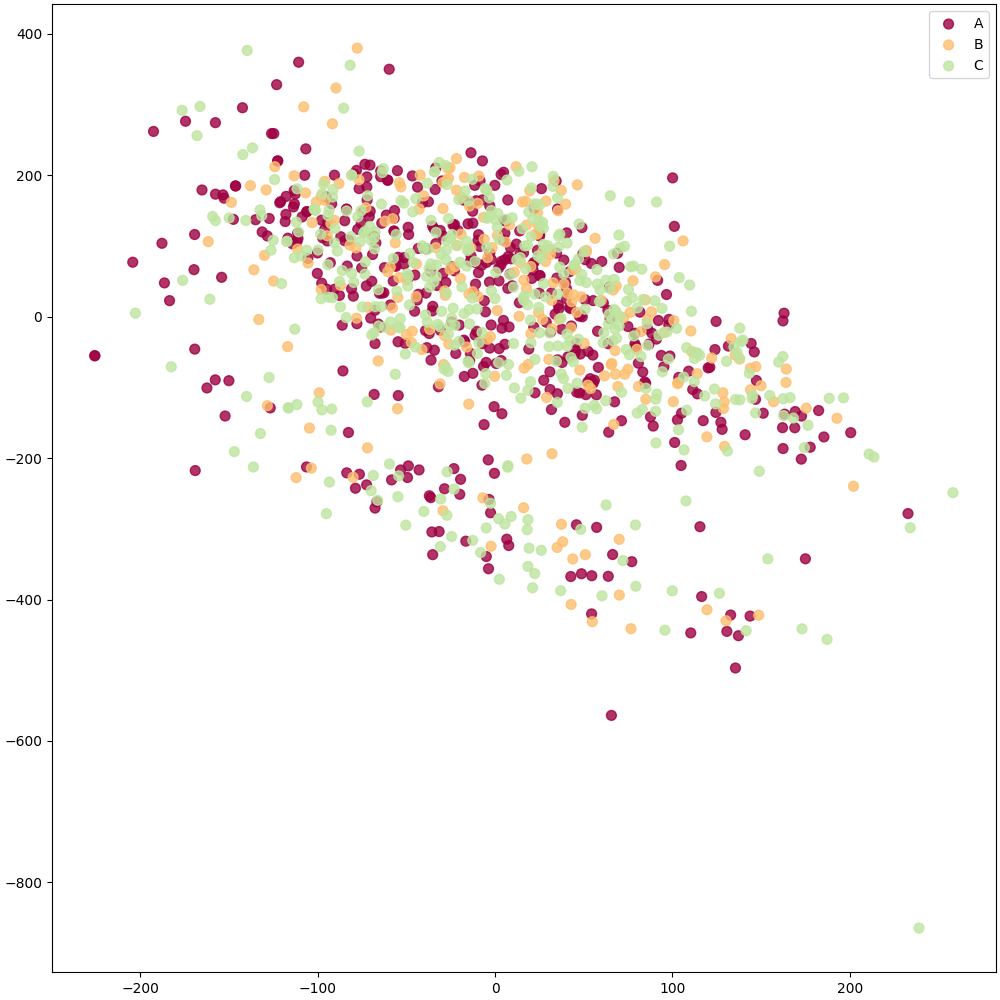

In [47]:
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
cmap = matplotlib.colormaps['Spectral']

categories = features.violin
labels = sklearn.preprocessing.LabelEncoder().fit_transform(categories)
# markers = sklearn.preprocessing.LabelEncoder().fit_transform(features.extract)
colors = cmap(labels / len(set(categories)))

for category in set(categories):
    ax.scatter(
        x[categories==category], y[categories==category], 
        color=colors[categories==category], 
        label=category, 
        alpha=0.8, 
        s=50,
        # s=markers[categories==category],
    )

ax.legend()

# pos = np.where(features.index == wrong_idx[0])[0]
# ax.scatter(x[pos], y[pos], s=50, edgecolors='red' , marker='o', facecolors='none')

# neigh_idx = X_train.iloc[neigh_ind[wrong_pos[0]]].index.to_list()
# neigh_idx = np.where(features.index.isin(neigh_idx))[0]
# ax.scatter(x[neigh_idx], y[neigh_idx], s=50, edgecolors='green', marker='o', facecolors='none')

plt.show()

## 3D

In [51]:
embedding = sklearn.manifold.MDS(n_components=3, normalized_stress=False, n_jobs=-1)
# embedding = sklearn.manifold.Isomap(n_components=3, n_jobs=-1, n_neighbors=55)
X = np.vstack(features.features)
X = X[:, :15]
points = embedding.fit_transform(X)
x, y, z = points.T

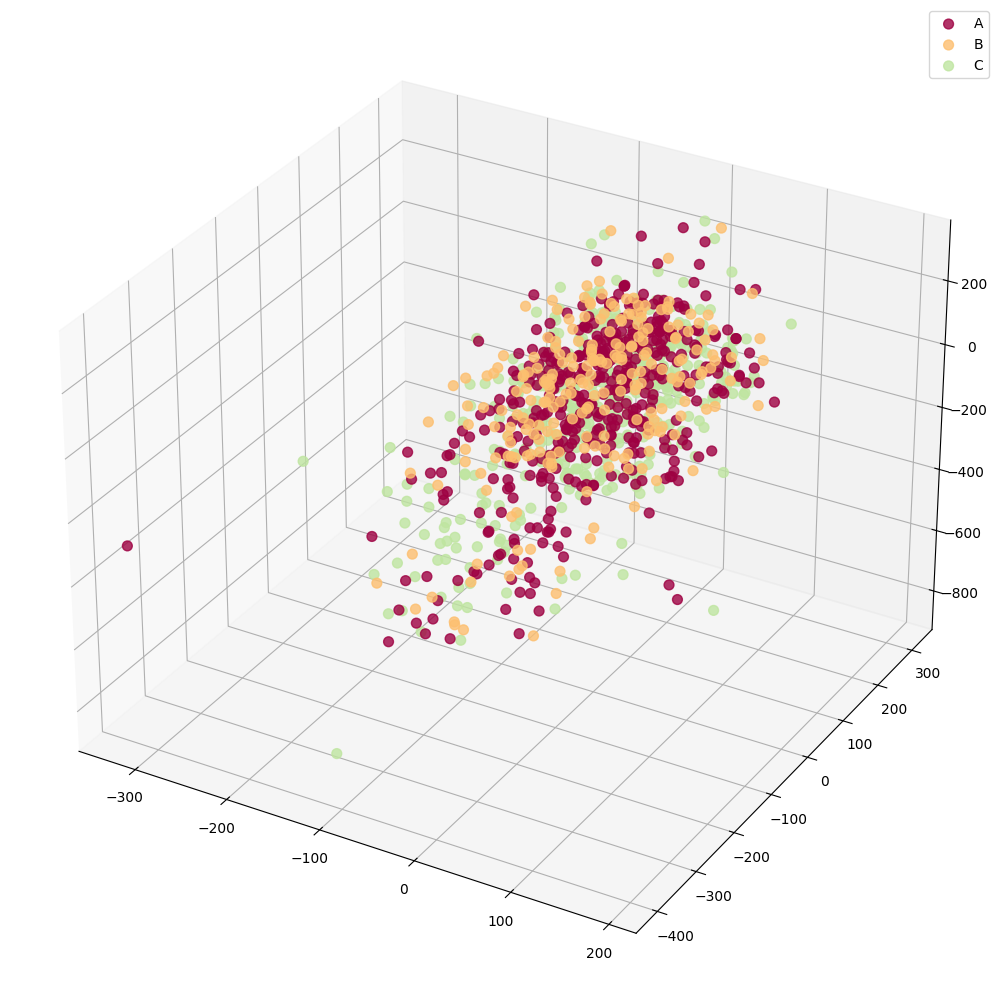

In [52]:
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True, subplot_kw={"projection": "3d"})
cmap = matplotlib.colormaps['Spectral']

categories = features.violin
labels = sklearn.preprocessing.LabelEncoder().fit_transform(categories)
colors = cmap(labels / len(set(categories)))

for category in set(categories):
    ax.scatter(
        x[categories==category], y[categories==category], z[categories==category],
        color=colors[categories==category], s=50, alpha=0.8, label=category
    )
ax.legend()

# idx = np.where(features.index == wrong_idx[0])[0]
# ax.scatter(x[idx], y[idx], z[idx], s=60, edgecolors='red', marker='o', facecolors='none')

# neigh_idx = X_train.iloc[neigh_ind[wrong_pos[0]]].index.to_list()
# neigh_idx = np.where(features.index.isin(neigh_idx))[0]
# ax.scatter(x[neigh_idx], y[neigh_idx], z[neigh_idx], s=60, edgecolors='green', marker='o', facecolors='none')

plt.show()